In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
import optuna
from optuna.integration import CatBoostPruningCallback

import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [4]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

## Эксперимент 6 Подбор гиперпараметров катбуста
На лучшем фича селекшене и с учётом эксперимента про кросс-валидацию (CV ухудшает метрику, подбираем без неё)

In [5]:
outliers_data_x = pd.read_csv("2_best_features_permutation.csv")
outliers_data_y = pd.read_csv("1_outliers_raw_data")["TARGET"]

In [6]:
def objective(trial: optuna.Trial) -> float:
    X = outliers_data_x
    y = outliers_data_y
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.5),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "5gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=50,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-07-08 16:02:31,022] A new study created in memory with name: no-name-88e15d1c-a2a4-40a6-8389-df34746b9545
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.5609392	best: 0.5609392 (0)	total: 145ms	remaining: 2m 25s
50:	test: 0.7230879	best: 0.7413996 (20)	total: 404ms	remaining: 7.51s
100:	test: 0.7416557	best: 0.7418812 (95)	total: 648ms	remaining: 5.77s
150:	test: 0.7368445	best: 0.7461115 (113)	total: 906ms	remaining: 5.09s
200:	test: 0.7591392	best: 0.7601482 (194)	total: 1.15s	remaining: 4.58s
250:	test: 0.7625881	best: 0.7631617 (239)	total: 1.39s	remaining: 4.16s
300:	test: 0.7606345	best: 0.7649636 (268)	total: 1.62s	remaining: 3.77s
350:	test: 0.7665483	best: 0.7670543 (345)	total: 1.86s	remaining: 3.43s
400:	test: 0.7703754	best: 0.7716078 (381)	total: 2.09s	remaining: 3.12s
450:	test: 0.7703806	best: 0.7716078 (381)	total: 2.33s	remaining: 2.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7716078376
bestIteration = 381

Shrink model to first 382 iterations.


[I 2024-07-08 16:02:33,884] Trial 0 finished with value: 0.7401826484018265 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.012010029605246619, 'learning_rate': 0.0033537504378625387, 'depth': 5, 'boosting_type': 'Ordered', 'l2_leaf_reg': 2, 'min_data_in_leaf': 1, 'random_strength': 1.2549441634794463, 'bootstrap_type': 'Bernoulli', 'subsample': 0.41834144010216534}. Best is trial 0 with value: 0.7401826484018265.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.52ms	remaining: 4.52s
50:	test: 0.8363050	best: 0.8408575 (49)	total: 1.14s	remaining: 21.3s
100:	test: 0.8410674	best: 0.8417334 (87)	total: 1.79s	remaining: 15.9s
150:	test: 0.8436838	best: 0.8442687 (138)	total: 2.93s	remaining: 16.5s
200:	test: 0.8418622	best: 0.8442687 (138)	total: 3.65s	remaining: 14.5s


[I 2024-07-08 16:02:38,189] Trial 1 finished with value: 0.8239726027397261 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.05222245951679426, 'learning_rate': 0.0689179446681468, 'depth': 10, 'boosting_type': 'Ordered', 'l2_leaf_reg': 4, 'min_data_in_leaf': 14, 'random_strength': 1.4091639058568666, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.8239726027397261.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8442687242
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.6645879	best: 0.6645879 (0)	total: 4.43ms	remaining: 4.42s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


50:	test: 0.7876413	best: 0.7922896 (46)	total: 170ms	remaining: 3.15s
100:	test: 0.8155926	best: 0.8155926 (100)	total: 343ms	remaining: 3.05s
150:	test: 0.8177726	best: 0.8177726 (148)	total: 516ms	remaining: 2.9s
200:	test: 0.8195641	best: 0.8197623 (195)	total: 685ms	remaining: 2.72s
250:	test: 0.8236754	best: 0.8240024 (240)	total: 852ms	remaining: 2.54s
300:	test: 0.8251142	best: 0.8258296 (277)	total: 1.03s	remaining: 2.4s
350:	test: 0.8274765	best: 0.8274765 (349)	total: 1.19s	remaining: 2.2s
400:	test: 0.8275845	best: 0.8289222 (381)	total: 1.38s	remaining: 2.06s
450:	test: 0.8290698	best: 0.8295346 (446)	total: 1.55s	remaining: 1.88s
500:	test: 0.8298625	best: 0.8301955 (480)	total: 1.71s	remaining: 1.71s
550:	test: 0.8323566	best: 0.8324587 (549)	total: 1.9s	remaining: 1.55s
600:	test: 0.8326103	best: 0.8329016 (563)	total: 2.06s	remaining: 1.37s
650:	test: 0.8338678	best: 0.8343236 (626)	total: 2.24s	remaining: 1.2s
700:	test: 0.8344415	best: 0.8347903 (685)	total: 2.41s	re

[I 2024-07-08 16:02:42,699] Trial 2 finished with value: 0.7954337899543379 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.05700733984483394, 'learning_rate': 0.01473575420455683, 'depth': 5, 'boosting_type': 'Plain', 'l2_leaf_reg': 2, 'min_data_in_leaf': 27, 'random_strength': 0.3429562942493219, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.257180297886558}. Best is trial 1 with value: 0.8239726027397261.


999:	test: 0.8405177	best: 0.8405177 (999)	total: 3.45s	remaining: 0us

bestTest = 0.8405176856
bestIteration = 999

0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.64ms	remaining: 4.64s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


50:	test: 0.7652359	best: 0.7652359 (49)	total: 278ms	remaining: 5.17s
100:	test: 0.7769441	best: 0.7794594 (55)	total: 526ms	remaining: 4.68s
150:	test: 0.7933301	best: 0.7954023 (135)	total: 793ms	remaining: 4.46s
200:	test: 0.7963577	best: 0.7978003 (198)	total: 1.04s	remaining: 4.14s
250:	test: 0.7993331	best: 0.8000088 (227)	total: 1.29s	remaining: 3.86s
300:	test: 0.8026655	best: 0.8027687 (269)	total: 1.54s	remaining: 3.57s
350:	test: 0.8056780	best: 0.8056780 (350)	total: 1.78s	remaining: 3.29s
400:	test: 0.8077773	best: 0.8077773 (399)	total: 2.03s	remaining: 3.03s
450:	test: 0.8085331	best: 0.8086855 (402)	total: 2.29s	remaining: 2.79s
500:	test: 0.8082324	best: 0.8096008 (455)	total: 2.56s	remaining: 2.54s
550:	test: 0.8115146	best: 0.8116018 (546)	total: 2.81s	remaining: 2.29s
600:	test: 0.8121281	best: 0.8126795 (569)	total: 3.06s	remaining: 2.03s
650:	test: 0.8128219	best: 0.8128219 (650)	total: 3.3s	remaining: 1.77s
700:	test: 0.8152179	best: 0.8152179 (700)	total: 3.56s

[I 2024-07-08 16:02:48,888] Trial 3 finished with value: 0.760958904109589 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.01592569769129162, 'learning_rate': 0.02245892986381107, 'depth': 6, 'boosting_type': 'Ordered', 'l2_leaf_reg': 3, 'min_data_in_leaf': 27, 'random_strength': 0.43755251325033795, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.8239726027397261.


999:	test: 0.8239307	best: 0.8239377 (995)	total: 5.08s	remaining: 0us

bestTest = 0.8239376681
bestIteration = 995

Shrink model to first 996 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.29ms	remaining: 4.29s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


50:	test: 0.7324591	best: 0.7354948 (48)	total: 251ms	remaining: 4.67s
100:	test: 0.7749658	best: 0.7775510 (96)	total: 495ms	remaining: 4.4s
150:	test: 0.7798625	best: 0.7867755 (136)	total: 731ms	remaining: 4.11s
200:	test: 0.7918106	best: 0.7918106 (200)	total: 975ms	remaining: 3.88s
250:	test: 0.8019736	best: 0.8019736 (250)	total: 1.21s	remaining: 3.61s
300:	test: 0.8030345	best: 0.8039814 (281)	total: 1.45s	remaining: 3.36s
350:	test: 0.8051766	best: 0.8065272 (332)	total: 1.69s	remaining: 3.13s
400:	test: 0.8059680	best: 0.8065368 (377)	total: 1.92s	remaining: 2.87s
450:	test: 0.8097324	best: 0.8097324 (450)	total: 2.16s	remaining: 2.63s
500:	test: 0.8104897	best: 0.8106793 (499)	total: 2.4s	remaining: 2.39s
550:	test: 0.8099720	best: 0.8114878 (527)	total: 2.66s	remaining: 2.17s
600:	test: 0.8134318	best: 0.8137524 (573)	total: 2.89s	remaining: 1.92s
650:	test: 0.8157571	best: 0.8160788 (631)	total: 3.13s	remaining: 1.68s
700:	test: 0.8173410	best: 0.8173410 (700)	total: 3.36s	

[I 2024-07-08 16:02:54,776] Trial 4 finished with value: 0.752283105022831 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.038205731971610105, 'learning_rate': 0.061002909954895955, 'depth': 1, 'boosting_type': 'Ordered', 'l2_leaf_reg': 2, 'min_data_in_leaf': 27, 'random_strength': 1.430468020053079, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.080171932930043}. Best is trial 1 with value: 0.8239726027397261.


999:	test: 0.8265101	best: 0.8265101 (999)	total: 4.79s	remaining: 0us

bestTest = 0.8265101129
bestIteration = 999

0:	test: 0.6959245	best: 0.6959245 (0)	total: 7.39ms	remaining: 7.38s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


50:	test: 0.7953712	best: 0.8051046 (35)	total: 290ms	remaining: 5.39s
100:	test: 0.7924228	best: 0.8051046 (35)	total: 540ms	remaining: 4.8s


[I 2024-07-08 16:02:55,642] Trial 5 finished with value: 0.784703196347032 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.078332804492676, 'learning_rate': 0.0018101319949196952, 'depth': 7, 'boosting_type': 'Plain', 'l2_leaf_reg': 5, 'min_data_in_leaf': 26, 'random_strength': 0.2715062767360598, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.386646069493498}. Best is trial 1 with value: 0.8239726027397261.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8051045665
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.6499390	best: 0.6499390 (0)	total: 3.16ms	remaining: 3.16s
50:	test: 0.7841839	best: 0.7985034 (36)	total: 126ms	remaining: 2.34s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


100:	test: 0.7971383	best: 0.7985034 (36)	total: 257ms	remaining: 2.28s
150:	test: 0.8074111	best: 0.8074111 (150)	total: 380ms	remaining: 2.14s
200:	test: 0.8098280	best: 0.8098280 (200)	total: 509ms	remaining: 2.02s
250:	test: 0.8119903	best: 0.8120550 (249)	total: 643ms	remaining: 1.92s
300:	test: 0.8139768	best: 0.8139768 (300)	total: 774ms	remaining: 1.8s
350:	test: 0.8168766	best: 0.8168766 (350)	total: 899ms	remaining: 1.66s
400:	test: 0.8198058	best: 0.8198968 (392)	total: 1.02s	remaining: 1.52s
450:	test: 0.8229836	best: 0.8230866 (449)	total: 1.14s	remaining: 1.39s
500:	test: 0.8252489	best: 0.8254075 (496)	total: 1.27s	remaining: 1.26s
550:	test: 0.8259178	best: 0.8259178 (550)	total: 1.39s	remaining: 1.13s
600:	test: 0.8269696	best: 0.8273051 (594)	total: 1.51s	remaining: 1s
650:	test: 0.8271202	best: 0.8274192 (646)	total: 1.63s	remaining: 874ms
700:	test: 0.8305384	best: 0.8305384 (700)	total: 1.76s	remaining: 750ms
750:	test: 0.8318600	best: 0.8319358 (748)	total: 1.88s	

[I 2024-07-08 16:02:59,435] Trial 6 finished with value: 0.7995433789954338 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.07539805412945569, 'learning_rate': 0.07637482304387118, 'depth': 2, 'boosting_type': 'Plain', 'l2_leaf_reg': 2, 'min_data_in_leaf': 5, 'random_strength': 1.0466142272043752, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.5777972096146273}. Best is trial 1 with value: 0.8239726027397261.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2024-07-08 16:02:59,548] Trial 7 pruned. Trial was pruned at iteration 5.


999:	test: 0.8371121	best: 0.8374779 (993)	total: 2.51s	remaining: 0us

bestTest = 0.8374778594
bestIteration = 993

Shrink model to first 994 iterations.
0:	test: 0.5900061	best: 0.5900061 (0)	total: 10.7ms	remaining: 10.7s

bestTest = 0.6604868777
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.6088579	best: 0.6088579 (0)	total: 5.91ms	remaining: 5.9s


[I 2024-07-08 16:02:59,647] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2024-07-08 16:02:59,746] Trial 9 pruned. Trial was pruned at iteration 5.



bestTest = 0.6333693816
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 5.22ms	remaining: 5.21s

bestTest = 0.6184881356
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.5508864	best: 0.5508864 (0)	total: 2.02ms	remaining: 2.02s

bestTest = 0.6159151713
bestIteration = 4

Shrink model to first 5 iterations.


[I 2024-07-08 16:02:59,841] Trial 10 pruned. Trial was pruned at iteration 5.


0:	test: 0.7053338	best: 0.7053338 (0)	total: 100ms	remaining: 1m 39s
50:	test: 0.8186533	best: 0.8194913 (45)	total: 2.42s	remaining: 45.1s
100:	test: 0.8279951	best: 0.8297453 (90)	total: 4.57s	remaining: 40.7s
150:	test: 0.8322294	best: 0.8322294 (150)	total: 6.5s	remaining: 36.6s
200:	test: 0.8407682	best: 0.8408156 (199)	total: 8.81s	remaining: 35s
250:	test: 0.8445912	best: 0.8445995 (249)	total: 11.2s	remaining: 33.4s
300:	test: 0.8470063	best: 0.8472403 (292)	total: 13.9s	remaining: 32.2s
350:	test: 0.8475536	best: 0.8475557 (346)	total: 16.4s	remaining: 30.4s
400:	test: 0.8479927	best: 0.8481484 (398)	total: 18.8s	remaining: 28.1s
450:	test: 0.8490668	best: 0.8493121 (442)	total: 21s	remaining: 25.5s
500:	test: 0.8496904	best: 0.8498584 (497)	total: 23.8s	remaining: 23.7s
550:	test: 0.8497450	best: 0.8498584 (497)	total: 26s	remaining: 21.2s
600:	test: 0.8505583	best: 0.8506923 (592)	total: 28s	remaining: 18.6s
650:	test: 0.8512581	best: 0.8512581 (650)	total: 30.3s	remaining:

[I 2024-07-08 16:03:39,618] Trial 11 finished with value: 0.9529680365296803 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.08751576549931726, 'learning_rate': 0.08266927367375565, 'depth': 12, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 6, 'random_strength': 1.013229771021918, 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.9529680365296803.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.6942113	best: 0.6942113 (0)	total: 77.5ms	remaining: 1m 17s
50:	test: 0.8226055	best: 0.8226055 (50)	total: 2.15s	remaining: 39.9s
100:	test: 0.8417029	best: 0.8417029 (100)	total: 4.03s	remaining: 35.8s
150:	test: 0.8505742	best: 0.8505742 (150)	total: 5.95s	remaining: 33.5s
200:	test: 0.8563760	best: 0.8563760 (200)	total: 8.04s	remaining: 32s
250:	test: 0.8583913	best: 0.8591511 (242)	total: 10.1s	remaining: 30.3s
300:	test: 0.8619405	best: 0.8621460 (296)	total: 11.9s	remaining: 27.7s
350:	test: 0.8630397	best: 0.8632043 (345)	total: 14s	remaining: 25.9s
400:	test: 0.8635765	best: 0.8639865 (395)	total: 15.9s	remaining: 23.7s
450:	test: 0.8642053	best: 0.8644600 (446)	total: 18.1s	remaining: 22s
500:	test: 0.8656931	best: 0.8656931 (500)	total: 20.2s	remaining: 20.2s
550:	test: 0.8660786	best: 0.8663782 (523)	total: 22.1s	remaining: 18s
600:	test: 0.8663997	best: 0.8667033 (587)	total: 23.8s	remaining: 15.8s
650:	test: 0.8667872	best: 0.8667872 (649)	total: 26.1s	remaini

[I 2024-07-08 16:04:17,561] Trial 12 finished with value: 0.9557077625570777 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.09172959640015868, 'learning_rate': 0.09865632420179563, 'depth': 12, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 11, 'random_strength': 1.0842774474725296, 'bootstrap_type': 'MVS'}. Best is trial 12 with value: 0.9557077625570777.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.6956105	best: 0.6956105 (0)	total: 141ms	remaining: 2m 20s
50:	test: 0.8335132	best: 0.8342193 (44)	total: 4s	remaining: 1m 14s
100:	test: 0.8410239	best: 0.8435954 (81)	total: 8.06s	remaining: 1m 11s
150:	test: 0.8462106	best: 0.8474968 (137)	total: 12.3s	remaining: 1m 9s
200:	test: 0.8478620	best: 0.8480051 (192)	total: 16.4s	remaining: 1m 5s
250:	test: 0.8498503	best: 0.8498503 (250)	total: 20.3s	remaining: 1m
300:	test: 0.8505178	best: 0.8505695 (290)	total: 24s	remaining: 55.7s
350:	test: 0.8508474	best: 0.8509113 (306)	total: 28.2s	remaining: 52.1s
400:	test: 0.8521063	best: 0.8521063 (399)	total: 32.2s	remaining: 48.2s
450:	test: 0.8530832	best: 0.8530832 (450)	total: 36.2s	remaining: 44.1s
500:	test: 0.8533571	best: 0.8537689 (483)	total: 39.6s	remaining: 39.5s
550:	test: 0.8538156	best: 0.8538156 (550)	total: 43.6s	remaining: 35.5s
600:	test: 0.8540185	best: 0.8540682 (577)	total: 46.8s	remaining: 31.1s
650:	test: 0.8544709	best: 0.8544719 (647)	total: 50.4s	remaini

[I 2024-07-08 16:05:19,058] Trial 13 finished with value: 0.9568493150684931 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.09832781697949405, 'learning_rate': 0.09886336209561161, 'depth': 13, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 8, 'random_strength': 0.9050000844444728, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.6490032	best: 0.6490032 (0)	total: 813ms	remaining: 13m 32s
50:	test: 0.8203406	best: 0.8203406 (50)	total: 23.5s	remaining: 7m 18s
100:	test: 0.8330594	best: 0.8330594 (100)	total: 43.8s	remaining: 6m 29s
150:	test: 0.8400230	best: 0.8400230 (150)	total: 1m 9s	remaining: 6m 33s
200:	test: 0.8423904	best: 0.8424468 (197)	total: 1m 38s	remaining: 6m 32s
250:	test: 0.8455060	best: 0.8457376 (246)	total: 2m 4s	remaining: 6m 12s
300:	test: 0.8474018	best: 0.8476366 (298)	total: 2m 33s	remaining: 5m 56s
350:	test: 0.8492496	best: 0.8493509 (345)	total: 3m 3s	remaining: 5m 39s
400:	test: 0.8501637	best: 0.8502774 (398)	total: 3m 28s	remaining: 5m 11s
450:	test: 0.8511079	best: 0.8511079 (450)	total: 3m 51s	remaining: 4m 41s
500:	test: 0.8519677	best: 0.8519687 (499)	total: 4m 21s	remaining: 4m 20s
550:	test: 0.8523109	best: 0.8523433 (546)	total: 4m 42s	remaining: 3m 50s
600:	test: 0.8524320	best: 0.8525301 (563)	total: 5m 8s	remaining: 3m 24s
650:	test: 0.8522431	best: 0.8525301 

[I 2024-07-08 16:10:59,574] Trial 14 finished with value: 0.9545662100456621 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.09877993275118978, 'learning_rate': 0.0977977378225585, 'depth': 15, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 10, 'random_strength': 0.6653570318531746, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.
C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.7089620	best: 0.7089620 (0)	total: 127ms	remaining: 2m 6s
50:	test: 0.8349004	best: 0.8367411 (38)	total: 857ms	remaining: 15.9s
100:	test: 0.8520082	best: 0.8520082 (99)	total: 2.13s	remaining: 18.9s
150:	test: 0.8620959	best: 0.8620959 (150)	total: 2.98s	remaining: 16.7s
200:	test: 0.8645721	best: 0.8645721 (200)	total: 3.63s	remaining: 14.4s
250:	test: 0.8719308	best: 0.8727219 (247)	total: 4.88s	remaining: 14.6s
300:	test: 0.8739776	best: 0.8740043 (299)	total: 5.36s	remaining: 12.4s
350:	test: 0.8748106	best: 0.8754470 (319)	total: 6.6s	remaining: 12.2s
400:	test: 0.8774909	best: 0.8774909 (400)	total: 7.22s	remaining: 10.8s
450:	test: 0.8782800	best: 0.8786808 (445)	total: 8.38s	remaining: 10.2s
500:	test: 0.8813984	best: 0.8814795 (497)	total: 8.89s	remaining: 8.86s
550:	test: 0.8829222	best: 0.8829308 (542)	total: 9.79s	remaining: 7.97s
600:	test: 0.8826646	best: 0.8830806 (593)	total: 10.7s	remaining: 7.1s
650:	test: 0.8833993	best: 0.8836197 (643)	total: 11.2s	rema

[I 2024-07-08 16:11:18,648] Trial 15 finished with value: 0.9538812785388128 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.057587580809996014, 'learning_rate': 0.09001114753135195, 'depth': 13, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 18, 'random_strength': 1.075431671481025, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.


999:	test: 0.8860396	best: 0.8863602 (975)	total: 17.5s	remaining: 0us

bestTest = 0.8863601666
bestIteration = 975

Shrink model to first 976 iterations.


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2024-07-08 16:11:18,746] Trial 16 pruned. Trial was pruned at iteration 5.


0:	test: 0.5571708	best: 0.5571708 (0)	total: 2.64ms	remaining: 2.64s

bestTest = 0.600632559
bestIteration = 4

Shrink model to first 5 iterations.
0:	test: 0.7074448	best: 0.7074448 (0)	total: 34.7ms	remaining: 34.7s
50:	test: 0.8247848	best: 0.8247848 (49)	total: 661ms	remaining: 12.3s
100:	test: 0.8372480	best: 0.8378054 (96)	total: 1.21s	remaining: 10.8s
150:	test: 0.8410455	best: 0.8419046 (146)	total: 1.75s	remaining: 9.84s
200:	test: 0.8477522	best: 0.8484790 (196)	total: 2.28s	remaining: 9.07s
250:	test: 0.8521603	best: 0.8522034 (245)	total: 2.92s	remaining: 8.71s
300:	test: 0.8546254	best: 0.8552159 (284)	total: 3.49s	remaining: 8.1s
350:	test: 0.8586364	best: 0.8587758 (348)	total: 4.08s	remaining: 7.55s
400:	test: 0.8609823	best: 0.8610014 (396)	total: 4.63s	remaining: 6.92s
450:	test: 0.8625873	best: 0.8625873 (450)	total: 5.21s	remaining: 6.34s
500:	test: 0.8633222	best: 0.8635337 (471)	total: 5.79s	remaining: 5.77s
550:	test: 0.8645643	best: 0.8645643 (550)	total: 6.28s

[I 2024-07-08 16:11:27,586] Trial 17 finished with value: 0.954337899543379 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.06650101276950493, 'learning_rate': 0.09870339839186383, 'depth': 11, 'boosting_type': 'Plain', 'l2_leaf_reg': 3, 'min_data_in_leaf': 14, 'random_strength': 0.12182586683927277, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8667286884
bestIteration = 583

Shrink model to first 584 iterations.
0:	test: 0.6889284	best: 0.6889284 (0)	total: 72.8ms	remaining: 1m 12s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2024-07-08 16:11:29,754] Trial 18 pruned. Trial was pruned at iteration 47.
[I 2024-07-08 16:11:29,869] Trial 19 pruned. Trial was pruned at iteration 5.



bestTest = 0.8185021432
bestIteration = 44

Shrink model to first 45 iterations.
0:	test: 0.5500819	best: 0.5500819 (0)	total: 3.07ms	remaining: 3.06s

bestTest = 0.7359090775
bestIteration = 2

Shrink model to first 3 iterations.
0:	test: 0.6282112	best: 0.6282112 (0)	total: 3.64ms	remaining: 3.63s


[I 2024-07-08 16:11:30,300] Trial 20 pruned. Trial was pruned at iteration 5.



bestTest = 0.7529976286
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.6771930	best: 0.6771930 (0)	total: 1.3s	remaining: 21m 38s


[I 2024-07-08 16:11:35,780] Trial 21 pruned. Trial was pruned at iteration 5.



bestTest = 0.7543854622
bestIteration = 5

Shrink model to first 6 iterations.


[I 2024-07-08 16:11:36,762] Trial 22 pruned. Trial was pruned at iteration 5.


0:	test: 0.6960987	best: 0.6960987 (0)	total: 728ms	remaining: 12m 6s

bestTest = 0.7358577426
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.6737343	best: 0.6737343 (0)	total: 122ms	remaining: 2m 1s
50:	test: 0.8241116	best: 0.8242390 (46)	total: 1.4s	remaining: 26s
100:	test: 0.8442531	best: 0.8447126 (97)	total: 3.01s	remaining: 26.8s
150:	test: 0.8532932	best: 0.8533947 (147)	total: 4.16s	remaining: 23.4s
200:	test: 0.8537279	best: 0.8543994 (177)	total: 5.29s	remaining: 21s
250:	test: 0.8561093	best: 0.8561093 (250)	total: 6.21s	remaining: 18.5s
300:	test: 0.8565092	best: 0.8568265 (261)	total: 7.28s	remaining: 16.9s
350:	test: 0.8573209	best: 0.8579944 (341)	total: 9.11s	remaining: 16.8s
400:	test: 0.8554299	best: 0.8579944 (341)	total: 10.4s	remaining: 15.6s


[I 2024-07-08 16:11:48,792] Trial 23 finished with value: 0.9522831050228311 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.06434861069238516, 'learning_rate': 0.09536626954733361, 'depth': 13, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 12, 'random_strength': 0.9478806502050703, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8579943519
bestIteration = 341

Shrink model to first 342 iterations.


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.6442854	best: 0.6442854 (0)	total: 37.8ms	remaining: 37.7s
50:	test: 0.8436275	best: 0.8436275 (50)	total: 1.23s	remaining: 22.8s
100:	test: 0.8492564	best: 0.8502944 (98)	total: 2.38s	remaining: 21.2s
150:	test: 0.8563356	best: 0.8564933 (147)	total: 3.69s	remaining: 20.7s
200:	test: 0.8600165	best: 0.8601381 (197)	total: 4.81s	remaining: 19.1s
250:	test: 0.8649733	best: 0.8652434 (245)	total: 6.04s	remaining: 18s
300:	test: 0.8685057	best: 0.8685800 (294)	total: 7.14s	remaining: 16.6s
350:	test: 0.8731483	best: 0.8731483 (350)	total: 8.4s	remaining: 15.5s
400:	test: 0.8757107	best: 0.8759467 (396)	total: 9.74s	remaining: 14.6s
450:	test: 0.8775485	best: 0.8776083 (445)	total: 11s	remaining: 13.4s
500:	test: 0.8791977	best: 0.8791977 (500)	total: 12.2s	remaining: 12.2s
550:	test: 0.8802708	best: 0.8802708 (550)	total: 13.3s	remaining: 10.8s
600:	test: 0.8803089	best: 0.8812871 (581)	total: 14.5s	remaining: 9.64s
650:	test: 0.8814840	best: 0.8814840 (650)	total: 15.9s	remain

[I 2024-07-08 16:12:12,384] Trial 24 finished with value: 0.9563926940639269 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.09946913636456166, 'learning_rate': 0.07401602971169596, 'depth': 11, 'boosting_type': 'Plain', 'l2_leaf_reg': 3, 'min_data_in_leaf': 8, 'random_strength': 1.1816714150575587, 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.9568493150684931.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8832228366
bestIteration = 871

Shrink model to first 872 iterations.


C:\Users\realn\AppData\Local\Temp\ipykernel_536\4097022430.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")
[I 2024-07-08 16:12:12,505] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2024-07-08 16:12:12,602] Trial 26 pruned. Trial was pruned at iteration 5.


0:	test: 0.6747752	best: 0.6747752 (0)	total: 21.3ms	remaining: 21.3s

bestTest = 0.7335899312
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.5364971	best: 0.5364971 (0)	total: 1.9ms	remaining: 1.9s

bestTest = 0.6210418075
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.5641606	best: 0.5641606 (0)	total: 2.65ms	remaining: 2.65s

bestTest = 0.5690222424
bestIteration = 5

Shrink model to first 6 iterations.


[I 2024-07-08 16:12:12,697] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2024-07-08 16:12:12,802] Trial 28 pruned. Trial was pruned at iteration 5.


0:	test: 0.5921375	best: 0.5921375 (0)	total: 8.44ms	remaining: 8.43s

bestTest = 0.6700116223
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.6552737	best: 0.6552737 (0)	total: 34.8ms	remaining: 34.7s

bestTest = 0.7442305541
bestIteration = 5

Shrink model to first 6 iterations.


[I 2024-07-08 16:12:12,978] Trial 29 pruned. Trial was pruned at iteration 5.


0:	test: 0.5559186	best: 0.5559186 (0)	total: 2.65ms	remaining: 2.65s


[I 2024-07-08 16:12:13,325] Trial 30 pruned. Trial was pruned at iteration 5.



bestTest = 0.7158011959
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.6646661	best: 0.6646661 (0)	total: 753ms	remaining: 12m 32s
50:	test: 0.8244856	best: 0.8249674 (45)	total: 23.5s	remaining: 7m 18s


[I 2024-07-08 16:12:41,742] Trial 31 pruned. Trial was pruned at iteration 59.



bestTest = 0.8249673652
bestIteration = 45

Shrink model to first 46 iterations.
Number of finished trials: 32
Best trial:
  Value: 0.9568493150684931
  Params: 
    objective: Logloss
    auto_class_weights: Balanced
    colsample_bylevel: 0.09832781697949405
    learning_rate: 0.09886336209561161
    depth: 13
    boosting_type: Plain
    l2_leaf_reg: 4
    min_data_in_leaf: 8
    random_strength: 0.9050000844444728
    bootstrap_type: MVS


In [ ]:
  Params: 
    objective: Logloss
    auto_class_weights: Balanced
    colsample_bylevel: 0.09832781697949405
    learning_rate: 0.09886336209561161
    depth: 13
    boosting_type: Plain
    l2_leaf_reg: 4
    min_data_in_leaf: 8
    random_strength: 0.9050000844444728
    bootstrap_type: MVS

In [7]:
catboost_model = CatBoostClassifier(
    iterations=1000,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    objective='Logloss',
    colsample_bylevel=0.09832781697949405,
    learning_rate=0.09886336209561161,
    depth=13,
    l2_leaf_reg=4,
    min_data_in_leaf=8,
    random_strength=0.9050000844444728,
    boosting_type="Plain",
    bootstrap_type="MVS",
    early_stopping_rounds=100,
    
)

0:	test: 0.7075588	best: 0.7075588 (0)	total: 141ms	remaining: 2m 21s
100:	test: 0.8296717	best: 0.8321550 (70)	total: 7.55s	remaining: 1m 7s
200:	test: 0.8446169	best: 0.8449424 (195)	total: 15.4s	remaining: 1m 1s
300:	test: 0.8525366	best: 0.8525366 (300)	total: 23.9s	remaining: 55.6s
400:	test: 0.8567332	best: 0.8567332 (400)	total: 31.2s	remaining: 46.5s
500:	test: 0.8591564	best: 0.8591603 (497)	total: 38.7s	remaining: 38.6s
600:	test: 0.8603661	best: 0.8604649 (569)	total: 46.2s	remaining: 30.7s
700:	test: 0.8606373	best: 0.8606373 (700)	total: 52.6s	remaining: 22.4s
800:	test: 0.8603138	best: 0.8607196 (705)	total: 58.8s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8607196126
bestIteration = 705

Shrink model to first 706 iterations.


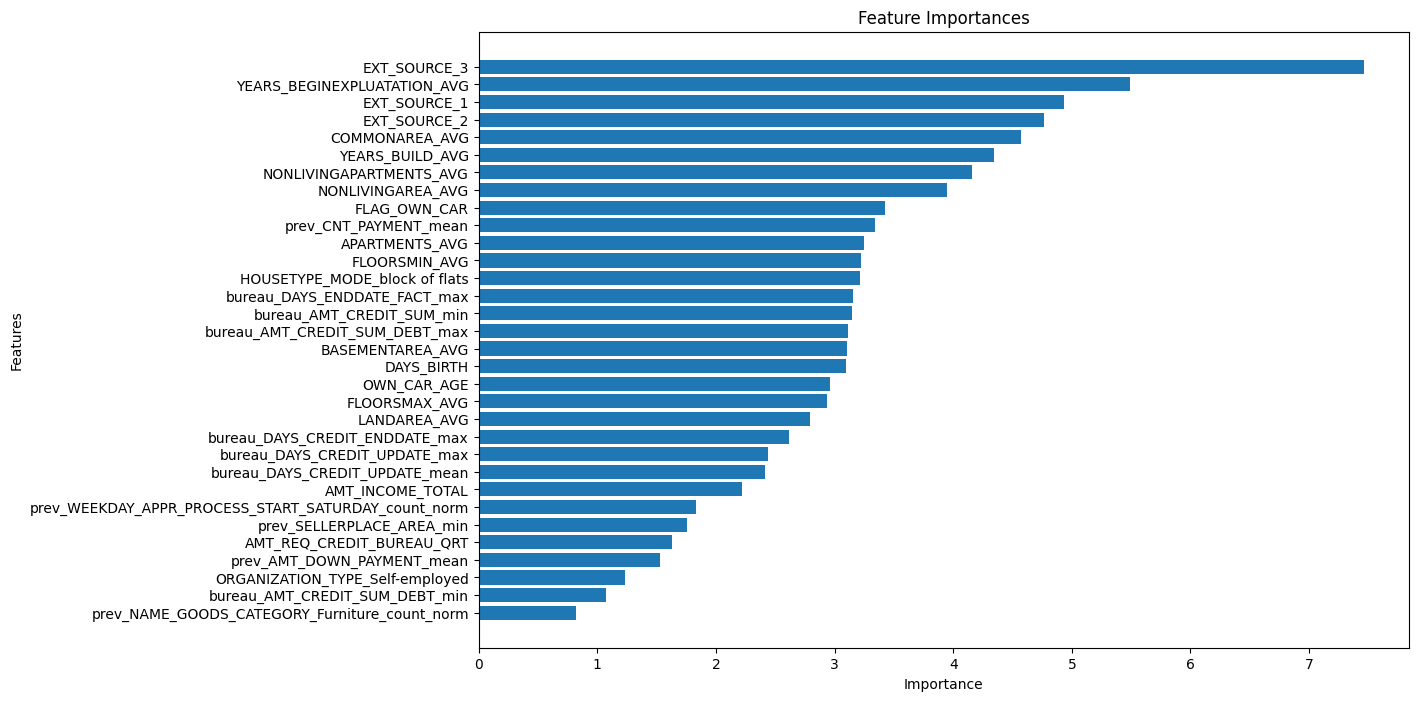

In [8]:
X = outliers_data_x
y = outliers_data_y

train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)

catboost_model.fit(train_X_cv, train_y_cv, eval_set=(test_X_cv, test_y_cv), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': train_X_cv.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model.get_best_score()

In [11]:
y_test_pred_dr = catboost_model.predict_proba(test_X_cv)
print(accuracy_score(y_true=test_y_cv, y_pred=y_test_pred_dr[:,1].round()))
print(roc_auc_score(y_true=test_y_cv, y_score=y_test_pred_dr[:,1], average="weighted"))
print(classification_report(test_y_cv, y_test_pred_dr[:,1].round()))

0.9511415525114155
0.860719612590799
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4130
           1       0.82      0.18      0.30       250

    accuracy                           0.95      4380
   macro avg       0.89      0.59      0.64      4380
weighted avg       0.95      0.95      0.94      4380



In [12]:
y_pred = y_test_pred_dr[:,1]
y = test_y_cv

wandb.init(
        project=project_name, name=exp_name+"6"+"_finetune_cv_balanced"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y, y_pred=y_pred.round()),
        "f1_score_weighted": f1_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "precision_weighted": precision_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y, y_probas = y_test_pred_dr)
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

wandb: Currently logged in as: qeshtir (qesh-squad). Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.95114
f1_score_weighted,0.93621
gini,0.72144
precision_weighted,0.94532
roc_auc_score,0.86072


### Тюнинг на всех фичах permutation

In [37]:
outliers_data_x = pd.read_csv("2_perm_full_features_out.csv")
outliers_data_y = pd.read_csv("1_outliers_raw_data")["TARGET"]
outliers_data_f = pd.read_csv("1_outliers_raw_data")

In [38]:
outliers_data_f = outliers_data_f[list(outliers_data_x["Features"])]

In [40]:
outliers_data_f.shape

(21897, 143)

In [41]:
def objective(trial: optuna.Trial) -> float:
    X = outliers_data_f
    y = outliers_data_y
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.5),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "5gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=50,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-07-08 16:42:55,327] A new study created in memory with name: no-name-cf02b6d6-a5a7-494b-a65a-5d2c3e055bcd
C:\Users\realn\AppData\Local\Temp\ipykernel_536\1231772092.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.6058762	best: 0.6058762 (0)	total: 3.17ms	remaining: 3.16s
50:	test: 0.7939029	best: 0.7939029 (50)	total: 135ms	remaining: 2.51s
100:	test: 0.8024784	best: 0.8048113 (94)	total: 268ms	remaining: 2.38s
150:	test: 0.7930975	best: 0.8048113 (94)	total: 396ms	remaining: 2.23s


[I 2024-07-08 16:42:55,995] Trial 0 finished with value: 0.7203196347031964 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.012406856001946487, 'learning_rate': 0.015299255966284162, 'depth': 2, 'boosting_type': 'Plain', 'l2_leaf_reg': 1, 'min_data_in_leaf': 18, 'random_strength': 0.2590181659679805, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7203196347031964.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8048113384
bestIteration = 94

Shrink model to first 95 iterations.
0:	test: 0.6877379	best: 0.6877379 (0)	total: 27.8ms	remaining: 27.8s


C:\Users\realn\AppData\Local\Temp\ipykernel_536\1231772092.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


50:	test: 0.8361908	best: 0.8379643 (33)	total: 1.51s	remaining: 28.1s
100:	test: 0.8414796	best: 0.8416155 (97)	total: 3.01s	remaining: 26.8s
150:	test: 0.8459749	best: 0.8459749 (150)	total: 4.48s	remaining: 25.2s
200:	test: 0.8488774	best: 0.8488840 (199)	total: 5.89s	remaining: 23.4s
250:	test: 0.8509377	best: 0.8509780 (249)	total: 7.29s	remaining: 21.8s
300:	test: 0.8541654	best: 0.8542825 (295)	total: 8.69s	remaining: 20.2s
350:	test: 0.8553327	best: 0.8558902 (337)	total: 10.2s	remaining: 18.8s
400:	test: 0.8556700	best: 0.8559127 (388)	total: 11.5s	remaining: 17.2s
450:	test: 0.8557394	best: 0.8559239 (437)	total: 12.8s	remaining: 15.6s
500:	test: 0.8564589	best: 0.8567597 (471)	total: 14.2s	remaining: 14.1s
550:	test: 0.8569424	best: 0.8570604 (537)	total: 15.5s	remaining: 12.6s
600:	test: 0.8571391	best: 0.8576207 (563)	total: 16.9s	remaining: 11.2s
650:	test: 0.8572853	best: 0.8576207 (563)	total: 18.3s	remaining: 9.81s


[I 2024-07-08 16:43:15,324] Trial 1 finished with value: 0.8289954337899543 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.06200592093154017, 'learning_rate': 0.01583692288317624, 'depth': 8, 'boosting_type': 'Ordered', 'l2_leaf_reg': 3, 'min_data_in_leaf': 11, 'random_strength': 0.29063265950423955, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.8289954337899543.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.857620681
bestIteration = 563

Shrink model to first 564 iterations.


C:\Users\realn\AppData\Local\Temp\ipykernel_536\1231772092.py:30: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.5152562	best: 0.5152562 (0)	total: 1.27s	remaining: 21m 10s
50:	test: 0.7541677	best: 0.7542778 (40)	total: 1m 8s	remaining: 21m 23s
100:	test: 0.7598250	best: 0.7598250 (100)	total: 2m 20s	remaining: 20m 46s
150:	test: 0.7653802	best: 0.7657480 (148)	total: 3m 37s	remaining: 20m 20s
200:	test: 0.7684720	best: 0.7685407 (194)	total: 4m 55s	remaining: 19m 35s
250:	test: 0.7702089	best: 0.7703635 (239)	total: 6m 14s	remaining: 18m 36s
300:	test: 0.7714780	best: 0.7714780 (300)	total: 7m 32s	remaining: 17m 31s
350:	test: 0.7722590	best: 0.7724904 (330)	total: 8m 42s	remaining: 16m 6s
400:	test: 0.7732684	best: 0.7734594 (399)	total: 9m 36s	remaining: 14m 20s
450:	test: 0.7736170	best: 0.7736170 (448)	total: 10m 23s	remaining: 12m 38s
500:	test: 0.7744021	best: 0.7744021 (499)	total: 11m 14s	remaining: 11m 11s
550:	test: 0.7744021	best: 0.7744021 (499)	total: 11m 51s	remaining: 9m 39s
600:	test: 0.7745011	best: 0.7747638 (559)	total: 12m 33s	remaining: 8m 20s
650:	test: 0.775107

[I 2024-07-08 17:00:16,292] Trial 2 finished with value: 0.945662100456621 and parameters: {'objective': 'Logloss', 'auto_class_weights': 'Balanced', 'colsample_bylevel': 0.08130937149681741, 'learning_rate': 0.07699703347031679, 'depth': 16, 'boosting_type': 'Plain', 'l2_leaf_reg': 1, 'min_data_in_leaf': 30, 'random_strength': 1.4292389419351479, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.271770643739193}. Best is trial 2 with value: 0.945662100456621.


Number of finished trials: 3
Best trial:
  Value: 0.945662100456621
  Params: 
    objective: Logloss
    auto_class_weights: Balanced
    colsample_bylevel: 0.08130937149681741
    learning_rate: 0.07699703347031679
    depth: 16
    boosting_type: Plain
    l2_leaf_reg: 1
    min_data_in_leaf: 30
    random_strength: 1.4292389419351479
    bootstrap_type: Bayesian
    bagging_temperature: 6.271770643739193


In [42]:
catboost_model_f = CatBoostClassifier(
    iterations=1000,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    objective='Logloss',
    colsample_bylevel=0.08130937149681741,
    learning_rate=0.07699703347031679,
    depth=16,
    l2_leaf_reg=1,
    min_data_in_leaf=30,
    random_strength=1.4292389419351479,
    boosting_type="Plain",
    bootstrap_type="Bayesian",
    bagging_temperature=6.271770643739193,
    early_stopping_rounds=100,
    
)

0:	test: 0.6413487	best: 0.6413487 (0)	total: 1.36s	remaining: 22m 43s
100:	test: 0.7923245	best: 0.7929908 (97)	total: 2m 19s	remaining: 20m 40s
200:	test: 0.7954431	best: 0.7954935 (198)	total: 4m 44s	remaining: 18m 51s
300:	test: 0.7985366	best: 0.7987312 (296)	total: 7m 21s	remaining: 17m 4s
400:	test: 0.7994169	best: 0.7995593 (365)	total: 9m 35s	remaining: 14m 20s
500:	test: 0.7991196	best: 0.7996494 (412)	total: 11m 15s	remaining: 11m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7996493947
bestIteration = 412

Shrink model to first 413 iterations.


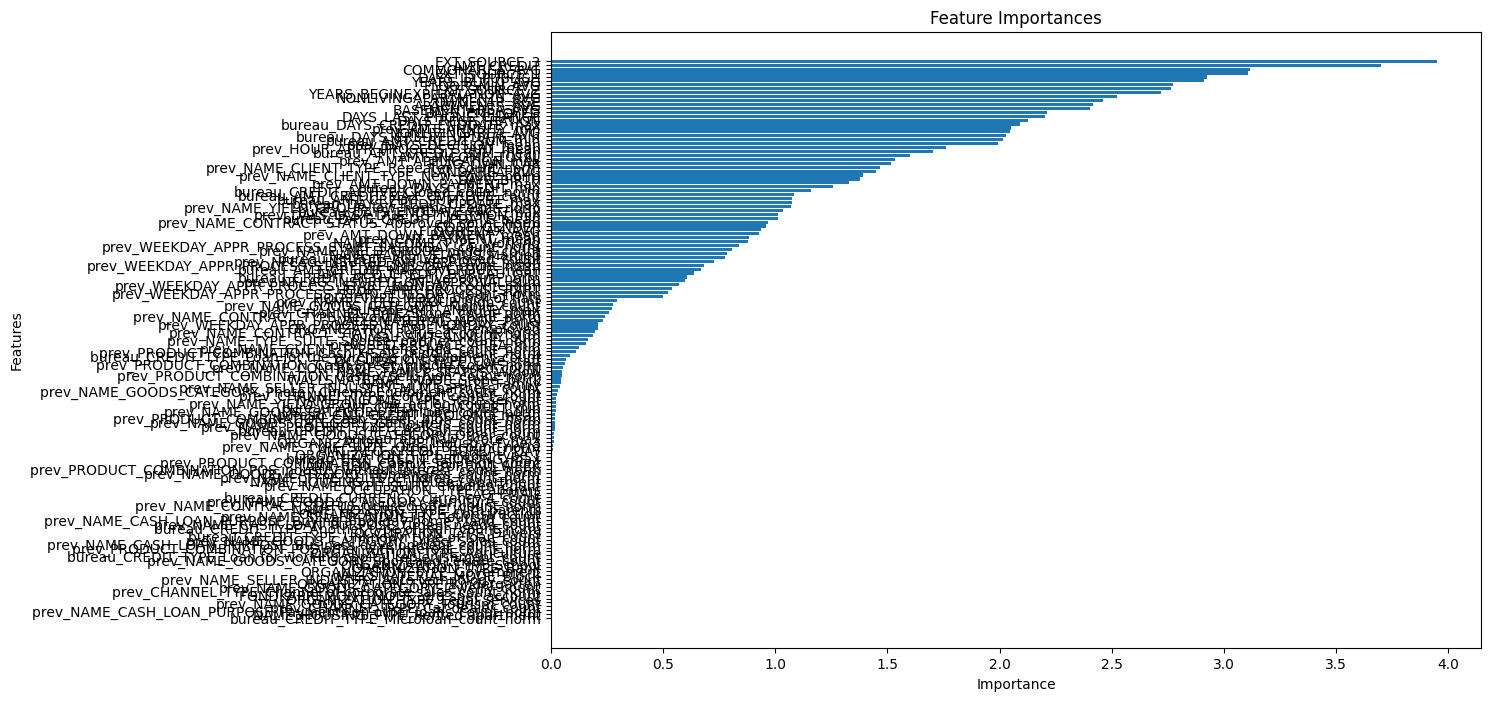

{'learn': {'Accuracy:use_weights=true': 1.0,
  'Logloss': 0.0013111286869530027,
  'Precision:use_weights=true': 1.0,
  'F1:use_weights=true': 1.0,
  'Recall:use_weights=true': 1.0},
 'validation': {'NormalizedGini:use_weights=true': 0.5992987893462469,
  'Accuracy:use_weights=true': 0.5700743582659027,
  'Logloss': 0.6712372791134994,
  'Precision:use_weights=true': 1.0,
  'F1:use_weights=true': 0.37407123077302235,
  'Recall:use_weights=true': 0.248,
  'AUC': 0.7996493946731235}}

In [43]:
X = outliers_data_f
y = outliers_data_y

train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)

catboost_model_f.fit(train_X_cv, train_y_cv, eval_set=(test_X_cv, test_y_cv), use_best_model=True)


# Get feature importances
feature_importances = catboost_model_f.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': train_X_cv.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model_f.get_best_score()

In [46]:
# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

0:	test: 0.6253182	best: 0.6253182 (0)	total: 1.25s	remaining: 20m 49s
100:	test: 0.7879215	best: 0.7894751 (86)	total: 1m 56s	remaining: 17m 19s
200:	test: 0.7959167	best: 0.7961317 (196)	total: 4m 10s	remaining: 16m 35s
300:	test: 0.7999429	best: 0.7999990 (283)	total: 6m 29s	remaining: 15m 4s
400:	test: 0.8004329	best: 0.8004755 (341)	total: 7m 54s	remaining: 11m 49s
500:	test: 0.8049288	best: 0.8049288 (498)	total: 8m 52s	remaining: 8m 50s
600:	test: 0.8057085	best: 0.8057085 (518)	total: 9m 51s	remaining: 6m 32s
700:	test: 0.8066179	best: 0.8066179 (694)	total: 10m 51s	remaining: 4m 37s
800:	test: 0.8069075	best: 0.8069094 (728)	total: 11m 46s	remaining: 2m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8069094431
bestIteration = 728

Shrink model to first 729 iterations.
0:	test: 0.5961724	best: 0.5961724 (0)	total: 1.22s	remaining: 20m 20s
100:	test: 0.7811748	best: 0.7811758 (98)	total: 1m 52s	remaining: 16m 38s
200:	test: 0.7914441	best: 0.7914441 (20

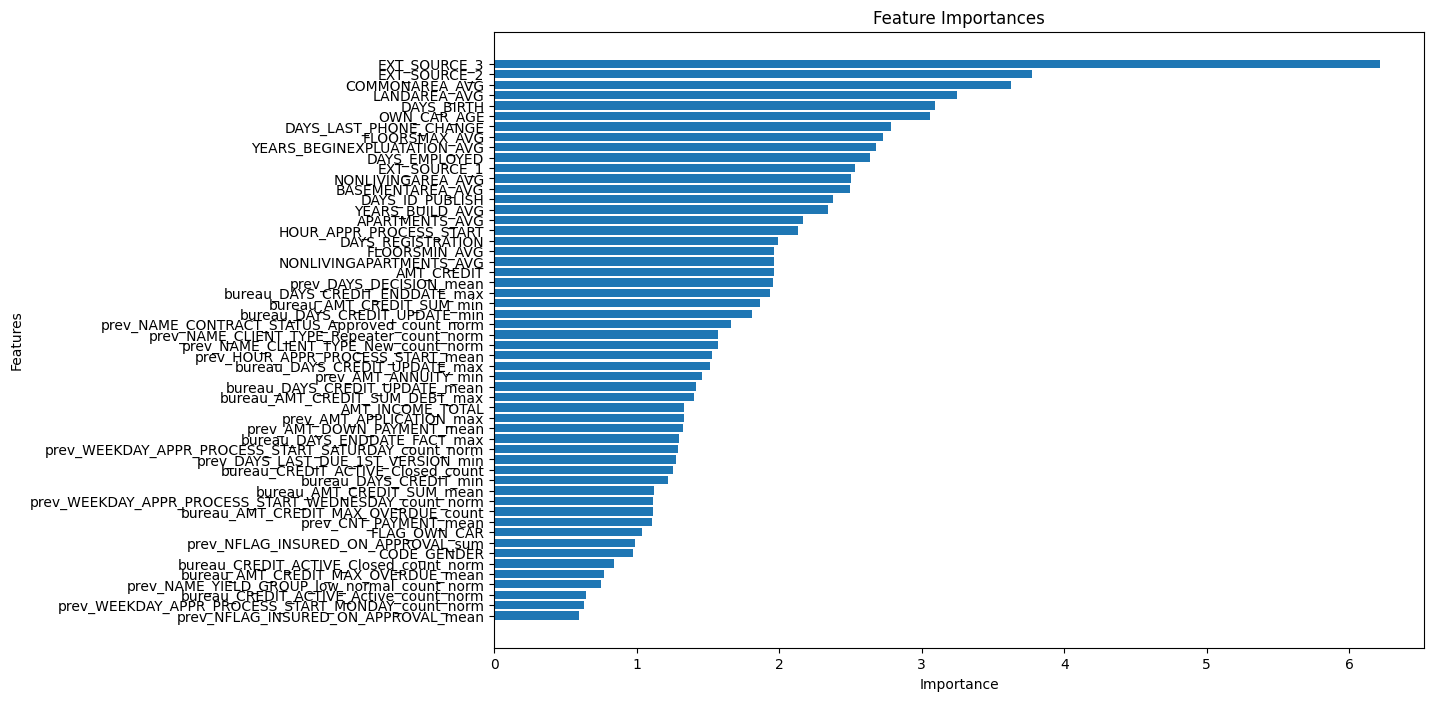

{'learn': {'Accuracy:use_weights=true': 1.0,
  'Logloss': 0.0016501722521865554,
  'Precision:use_weights=true': 1.0,
  'F1:use_weights=true': 1.0,
  'Recall:use_weights=true': 1.0},
 'validation': {'NormalizedGini:use_weights=true': 0.5993685230024213,
  'Accuracy:use_weights=true': 0.5956151127001448,
  'Logloss': 0.6653410455970251,
  'Precision:use_weights=true': 1.0,
  'F1:use_weights=true': 0.4596283371789736,
  'Recall:use_weights=true': 0.332,
  'AUC': 0.7996842615012106}}

In [48]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = outliers_data_f.drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped
    y_dr = outliers_data_y
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model_f.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model_f.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model_f.get_best_score()

In [49]:
y_test_pred_dr = catboost_model_f.predict_proba(test_X_cv)
print(accuracy_score(y_true=test_y_cv, y_pred=y_test_pred_dr[:,1].round()))
print(roc_auc_score(y_true=test_y_cv, y_score=y_test_pred_dr[:,1], average="weighted"))
print(classification_report(test_y_cv, y_test_pred_dr[:,1].round()))

0.9431506849315069
0.7996842615012107
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4130
           1       1.00      0.00      0.01       250

    accuracy                           0.94      4380
   macro avg       0.97      0.50      0.49      4380
weighted avg       0.95      0.94      0.92      4380



Видно что алгоритм сильно переобучился. Идея признана неудачной

In [50]:
y_pred = y_test_pred_dr[:,1]
y = test_y_cv

wandb.init(
        project=project_name, name=exp_name+"6.1"+"_finetune_cv_balanced_full_perm"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y, y_pred=y_pred.round()),
        "f1_score_weighted": f1_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "precision_weighted": precision_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y, y_probas = y_test_pred_dr)
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.94315
f1_score_weighted,0.91578
gini,0.59937
precision_weighted,0.94638
roc_auc_score,0.79968


## Квантизация золотых фичей
https://catboost.ai/en/docs/concepts/parameter-tuning#golden-features

In [51]:
outliers_data_x = pd.read_csv("2_best_features_permutation.csv")
outliers_data_y = pd.read_csv("1_outliers_raw_data")["TARGET"]

In [63]:
# Индекс золотой фичи
outliers_data_x.columns.get_loc("EXT_SOURCE_3")

31

In [64]:
catboost_model = CatBoostClassifier(
    iterations=1000,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42,
    objective='Logloss',
    colsample_bylevel=0.09832781697949405,
    learning_rate=0.09886336209561161,
    depth=13,
    l2_leaf_reg=4,
    min_data_in_leaf=8,
    random_strength=0.9050000844444728,
    boosting_type="Plain",
    bootstrap_type="MVS",
    early_stopping_rounds=100,
    per_float_feature_quantization=['31:border_count=1024']
    
)

0:	test: 0.7147690	best: 0.7147690 (0)	total: 194ms	remaining: 3m 13s
100:	test: 0.8308426	best: 0.8312213 (99)	total: 11.5s	remaining: 1m 41s
200:	test: 0.8484707	best: 0.8484707 (200)	total: 23.7s	remaining: 1m 34s
300:	test: 0.8543942	best: 0.8551177 (286)	total: 36.1s	remaining: 1m 23s
400:	test: 0.8584378	best: 0.8584755 (398)	total: 48s	remaining: 1m 11s
500:	test: 0.8594925	best: 0.8600823 (475)	total: 1m	remaining: 59.9s
600:	test: 0.8601153	best: 0.8601947 (569)	total: 1m 11s	remaining: 47.3s
700:	test: 0.8605772	best: 0.8607409 (680)	total: 1m 20s	remaining: 34.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8607409201
bestIteration = 680

Shrink model to first 681 iterations.


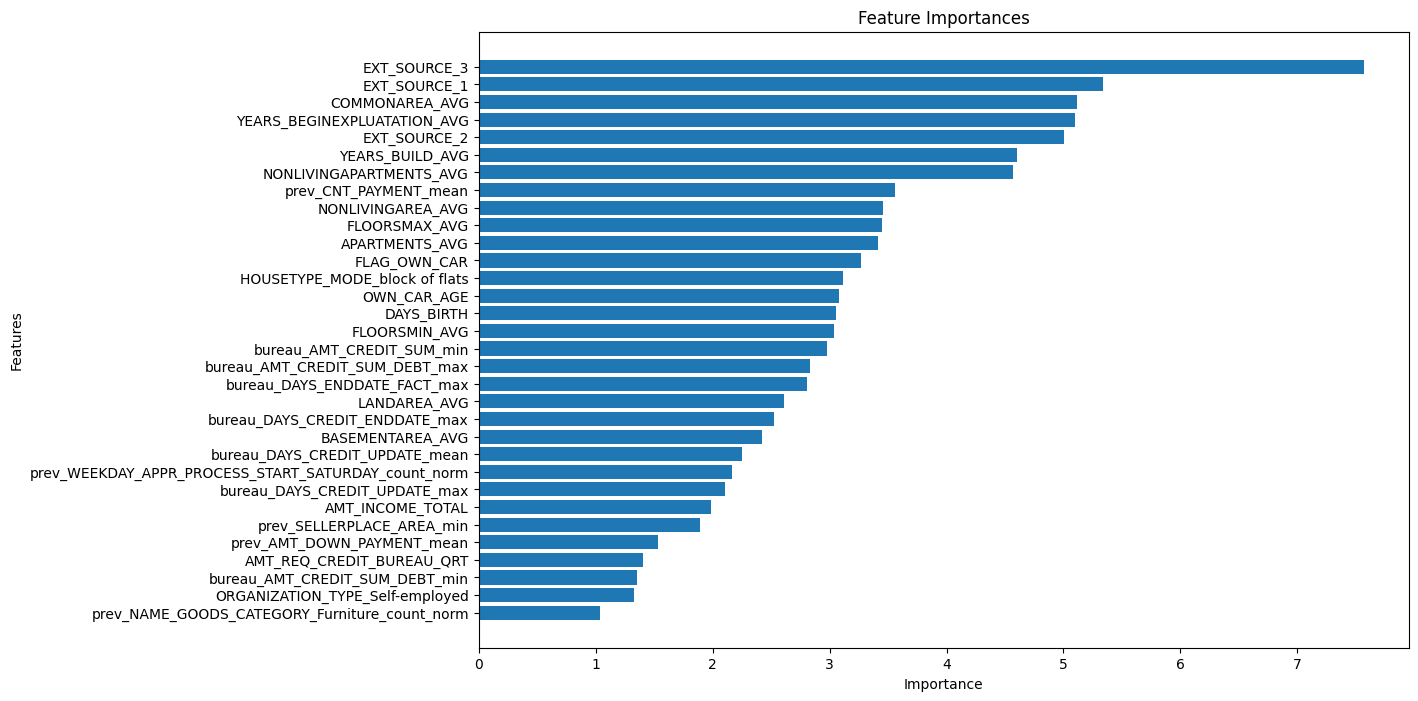

{'learn': {'Accuracy:use_weights=true': 1.0,
  'Logloss': 0.00233158630782592,
  'Precision:use_weights=true': 1.0,
  'F1:use_weights=true': 1.0,
  'Recall:use_weights=true': 1.0},
 'validation': {'NormalizedGini:use_weights=true': 0.7214818401937046,
  'Accuracy:use_weights=true': 0.6804458734888883,
  'Logloss': 0.6038067026572069,
  'Precision:use_weights=true': 0.9874859689643442,
  'F1:use_weights=true': 0.612687058935825,
  'Recall:use_weights=true': 0.508,
  'AUC': 0.8607409200968523}}

In [65]:
X = outliers_data_x
y = outliers_data_y

train_X_cv, test_X_cv, train_y_cv, test_y_cv = train_test_split(X, y, train_size=0.8, random_state=42)

catboost_model.fit(train_X_cv, train_y_cv, eval_set=(test_X_cv, test_y_cv), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': train_X_cv.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
catboost_model.get_best_score()

In [66]:
y_test_pred_dr = catboost_model.predict_proba(test_X_cv)
print(accuracy_score(y_true=test_y_cv, y_pred=y_test_pred_dr[:,1].round()))
print(roc_auc_score(y_true=test_y_cv, y_score=y_test_pred_dr[:,1], average="weighted"))
print(classification_report(test_y_cv, y_test_pred_dr[:,1].round()))

0.95
0.8607409200968522
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4130
           1       0.82      0.16      0.27       250

    accuracy                           0.95      4380
   macro avg       0.88      0.58      0.62      4380
weighted avg       0.94      0.95      0.93      4380



In [67]:
y_pred = y_test_pred_dr[:,1]
y = test_y_cv

wandb.init(
        project=project_name, name=exp_name+"6.3"+"_finetune_tss_balanced_quantization_fixed"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y, y_pred=y_pred.round()),
        "f1_score_weighted": f1_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "precision_weighted": precision_score(y_true=y, y_pred=y_pred.round(), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y, y_probas = y_test_pred_dr)
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.95
f1_score_weighted,0.93379
gini,0.72148
precision_weighted,0.9438
roc_auc_score,0.86074


In [68]:
catboost_model.save_model('cbm_best_finetuned.cbm', format='cbm')